### Obsluga plików

In [1]:
import pandas as pd
from scipy.signal import resample, butter, filtfilt, freqs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
import os
import json

In [3]:
def load_garmin_json_data(folder_path: str) -> pd.DataFrame:
    """
    Ładuje wszystkie pliki JSON EKG z folderu i zwraca DataFrame z kolumnami:
    - startTime: czas rozpoczęcia w ms od epoki
    - samples: lista sampli
    """
    records: List[Tuple[int, List[float]]] = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".json"):
            path = os.path.join(folder_path, filename)
            with open(path, "r") as f:
                data = json.load(f)

            try:
                samples = data["reading"]["samples"]
                start_time_ms = data["summary"]["startTime"]
            except (TypeError, KeyError):
                continue

            if isinstance(samples, (list, tuple)):
                records.append((start_time_ms, list(samples)))

    df = pd.DataFrame(records, columns=["startTime", "I"])
    return df

folder_g_1 = "data/N36/GARMIN-RECORDINGS/"
folder_g_2 = "data/N38/GARMIN-RECORDINGS/"
df_g_1 = load_garmin_json_data(folder_g_1)
df_g_2 = load_garmin_json_data(folder_g_2)

garminData = [df_g_1, df_g_2]

print(df_g_1.shape)
print(df_g_2.shape)
print(df_g_1.head())
print(df_g_2.head())

(4, 2)
(10, 2)
       startTime                                                  I
0  1763109973000  [0.024760665, 0.018534927, 0.009863188, -0.000...
1  1763109857000  [0.31462502, 0.12551546, 0.36973786, 0.1507331...
2  1763110128000  [-0.06232079, -0.0589571, -0.053055074, -0.044...
3  1763110210000  [-0.044223633, -0.048709895, -0.0450845, -0.03...
       startTime                                                  I
0  1763115490000  [0.011657256, 0.030320317, 0.052587938, 0.0760...
1  1763116434000  [-0.036527097, 0.12284678, -0.07840812, 0.0454...
2  1763115625000  [0.11368501, 0.041161176, 0.080935486, 0.16085...
3  1763116704000  [0.0061546047, 0.018407064, 0.041809894, 0.067...
4  1763116266000  [0.20442533, 0.50519806, 0.12913334, 0.0336892...


In [4]:
df_g_1['startTime'] = pd.to_datetime(df_g_1['startTime'], unit='ms')
df_g_1['startTime'] = df_g_1['startTime'].dt.strftime('%H:%M:%S')

df_g_2['startTime'] = pd.to_datetime(df_g_2['startTime'], unit='ms')
df_g_2['startTime'] = df_g_2['startTime'].dt.strftime('%H:%M:%S')



In [5]:

file_m_1 = 'data/N36/N36_2025-EKG-2025-11-14-09-48-38.csv'
file_m_2 = 'data/N38/N38_2025-2025-11-14-11-18-06.csv'

df_m_1 = pd.read_csv(file_m_1)
df_m_2 = pd.read_csv(file_m_2)

raw_list_m = [df_m_1, df_m_2]


In [6]:
import re

from datetime import datetime

time_pattern = r"(\d{4}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2})"

def extract_start_time(path: str) -> datetime:
    match = re.search(time_pattern, path)
    if not match:
        raise ValueError(f"Nie znaleziono znacznika czasu w nazwie pliku: {path}")
    return datetime.strptime(match.group(1), "%Y-%m-%d-%H-%M-%S")


start_time_1 = extract_start_time(file_m_1)
start_time_2 = extract_start_time(file_m_2)

print(f"N36 - Czas rozpoczęcia: {start_time_1}")
print(f"N38 - Czas rozpoczęcia: {start_time_2}")
print()

N36 - Czas rozpoczęcia: 2025-11-14 09:48:38
N38 - Czas rozpoczęcia: 2025-11-14 11:18:06



## Resampling (Zmiana częstotliwości próbkowania)

Jednym z kluczowych wyzwań w porównywaniu sygnałów z różnych urządzeń jest różnica w ich rozdzielczości czasowej. W analizowanym przypadku:

- **Aparatura medyczna** rejestruje sygnał z częstotliwością **500 Hz** (500 próbek na sekundę).
- **Smartwatch Garmin** rejestruje sygnał z częstotliwością **128 Hz** (128 próbek na sekundę).

Aby umożliwić bezpośrednie nałożenie na siebie sygnałów konieczne było sprowadzenie ich do wspólnej częstotliwości próbkowania. Proces ten nazywamy **resamplingiem**. Może on przybierać dwie formy:

### Rodzaje resamplingu

1.  **Downsampling (Decymacja)**
    Polega na zmniejszeniu częstotliwości próbkowania. W najprostszej formie oznacza to zachowanie co $n$-tej próbki i odrzucenie pozostałych. Proces ten wiąże się z ryzykiem wystąpienia zjawiska **aliasingu** (nakładania się widm).  Dlatego przed redukcją próbek konieczne jest zastosowanie filtra dolnoprzepustowego (antyaliasingowego), aby usunąć częstotliwości wyższe niż połowa nowej częstotliwości próbkowania (zgodnie z twierdzeniem Nyquista). 

2.  **Upsampling (Interpolacja)**
    Polega na zwiększeniu częstotliwości próbkowania. Proces ten polega na wstawieniu dodatkowych próbek pomiędzy te już istniejące (np. zer), a następnie zastosowaniu filtra interpolacyjnego, który "wygładza" sygnał, uzupełniając brakujące wartości na podstawie sąsiednich punktów. Upsampling nie dodaje nowych informacji do sygnału, ale zwiększa jego rozdzielczość czasową. 

### Implementacja w projekcie

W celu ujednolicenia danych zdecydowano się na **downsampling** sygnału medycznego do częstotliwości zegarka (128 Hz). 

- Pozwala na zmianę częstotliwości o dowolny ułamek wymierny (stosunek 128/500 nie jest liczbą całkowitą), wykonując upsampling i downsampling w jednym kroku.
- Automatycznie aplikuje filtr antyaliasingowy, zapobiegając zniekształceniom sygnału podczas redukcji liczby próbek.


In [7]:
def resample_data(df, g_freq = 128, m_freq = 500):

    number_of_new_samples = int(len(df) * (g_freq/m_freq))
    resampled_data = resample(df, number_of_new_samples)
    resampled_df = pd.DataFrame(resampled_data, columns=df.columns)
    return resampled_df

In [8]:
resampled_df_1 = resample_data(df_m_1)
resamples_df_2 = resample_data(df_m_2)

resampled_list = [resampled_df_1, resamples_df_2]

### Filtracja danych (Filtering data)

Surowy sygnał EKG zarejestrowany przez urządzenia (zarówno aparaturę kliniczną, jak i smartwatch) rzadko nadaje się do bezpośredniej analizy. Jest on zanieczyszczony różnego rodzaju szumami i artefaktami, które mogą zafałszować detekcję załamków QRS oraz analizę odcinka ST.

W celu usunięcia zakłóceń zastosowano **cyfrowy filtr pasmowo-przepustowy (Band-pass filter)**. W praktyce łączy on działanie dwóch filtrów:

1.  **Górnoprzepustowego (High-pass):**
    * **Cel:** Usunięcie składowych o bardzo niskiej częstotliwości, znanych jako **dryf linii bazowej** (ang. *Baseline Wander*).
    * **Przyczyna zakłóceń:** Zjawisko to objawia się "pływaniem" wykresu w górę i w dół. Głównym powodem jest oddychanie pacjenta (ruch klatki piersiowej zmieniający impedancję elektrod) oraz ruchy ciała.
    * **Rozwiązanie:** Zastosowanie odcięcia dolnego na poziomie **0.5 Hz**. Wszystkie zmiany sygnału wolniejsze niż 0.5 cyklu na sekundę są usuwane, co stabilizuje linię izoelektryczną na poziomie zera.

2.  **Dolnoprzepustowego (Low-pass):**
    * **Cel:** Usunięcie składowych o wysokiej częstotliwości.
    * **Przyczyna zakłóceń:** Sygnał EKG jest podatny na szum sieci energetycznej (50 Hz), aktywność mięśniową (szum EMG) oraz szum elektroniki sensora.
    * **Rozwiązanie:** Zastosowanie odcięcia górnego na poziomie **40 Hz**. Większość energii użytecznego sygnału EKG (załamki P, QRS, T) mieści się poniżej tej granicy. Usunięcie wyższych częstotliwości wygładza sygnał, eliminując "poszarpanie" wykresu.

low_cut = 0.5   # Usuwa oddech (High-pass)
high_cut = 40   # Usuwa szum sieciowy/miesniowy (Low-pass)


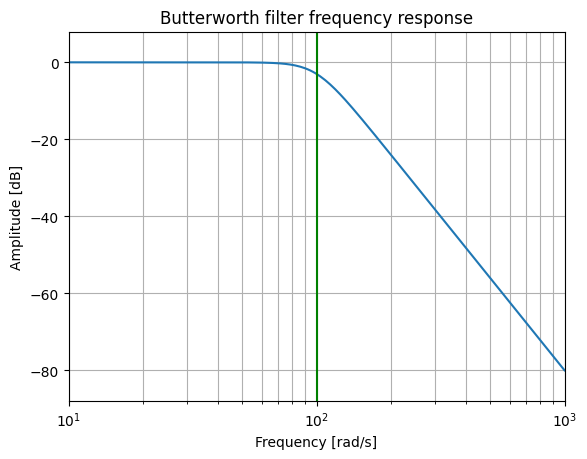

In [9]:
b, a = butter(4, 100, 'low', analog=True)
w, h = freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

### Normalizacja częstotliwości (Częstotliwość Nyquista)

Aby poprawnie wyznaczyć współczynniki filtra cyfrowego (takiego jak filtr Butterwortha), musimy operować na **częstotliwościach znormalizowanych**. Punktem odniesienia dla wszystkich operacji cyfrowych jest tzw. **Częstotliwość Nyquista**.

Jest to maksymalna częstotliwość, jaką można poprawnie zapisać (reprezentować) przy danej częstotliwości próbkowania ($f_s$). Wynosi ona dokładnie połowę częstotliwości próbkowania:

$$f_{Nyquist} = \frac{f_s}{2}$$

#### Dlaczego jest to konieczne?

1.  **Granica fizyczna sygnału cyfrowego:** Żaden system cyfrowy nie jest w stanie rozróżnić częstotliwości wyższych niż $f_{Nyquist}$ od częstotliwości niskich. Próba analizy sygnału o wyższej częstotliwości prowadzi do powstania błędu zwanego **aliasingiem** (nakładaniem widm), gdzie wysokie częstotliwości "udają" niskie, zafałszowując wynik. 

In [ ]:
def filter_ekg(data, fs=128, low_cut=0.5, high_cut=40, mode='medical'):
    
    nyquist = fs / 2
    norm_low = low_cut / nyquist
    norm_high = high_cut / nyquist
    
    b, a = butter(N=4, Wn=[norm_low, norm_high], btype='band')


    if mode == 'medical':
        filtered_data = filtfilt(b, a, data, axis=0)
        return pd.DataFrame(filtered_data, columns=data.columns, index=data.index)


    elif mode == 'watch':

        df_copy = data.copy()

        def _filter_list(signal_list):
            sig_array = np.array(signal_list)
            sig_array = np.nan_to_num(sig_array) 
            return filtfilt(b, a, sig_array) 
        
        df_copy = df_copy['I'].apply(_filter_list)

        
        return df_copy



# def filter_ekg(signal_data, frequency = 128):
    
    
#     fourier_frequency = frequency/2
#     low_cut = 0.5 #czestotliwosci wolniejsze od 0.5 to najprawdopodniej ruch klatki piersiowej, powodujacy drift 
#     high_cut = 40 # w tym przedziale znajduje sie najwiecej zlamkow, wieksze wartosci to w wiekszosci szum

#     normalized_low_cut = low_cut/fourier_frequency
#     normalized_high_cut = high_cut/fourier_frequency

#     b,a = butter(N = 4, Wn=[normalized_low_cut, normalized_high_cut], btype='band')

#     filtered_data = filtfilt(b, a, signal_data, axis = 0)

#     filtered_frame = pd.DataFrame(filtered_data, columns=signal_data.columns)

#     return filtered_frame

filtered_list_m = []
filtered_list_g = []

for df in garminData:
    filtered_list_g.append(filter_ekg(df, mode='watch'))


for df in resampled_list:
    filtered_list_m.append(filter_ekg(df, mode='medical'))



0    [-0.03220780390518582, -0.03713067740771089, -...
1    [-0.041730693644536083, -0.1353517745596666, -...
2    [-0.02767756708523491, -0.02383361633365601, -...
3    [0.01768029559886546, 0.012875141887729978, 0....
Name: I, dtype: object

### Porównanie wyników filtracji

W celu zmierzenia efektywnosci filtrowania dokonano dwóch wizualizacji.
- nałozenie dwóch sygnałów na siebie i przedstawienie ich na jedym wykresie, rozrózniając kolorami. 
- obliczenie róznicy sygnałów a następnie ich wizualizacja.

W przypadku róznicy im prostsza linia tym róznica pomiędzy filtrowanym sygnałem a nieprzetworzonym jest mniejsza.

##### Aparatura medyczna
Pomiary aparaturą medyczną cechują się wysoką dokładnoscią, więc zwizualizowana mała róznica jest poządanym wynikiem.



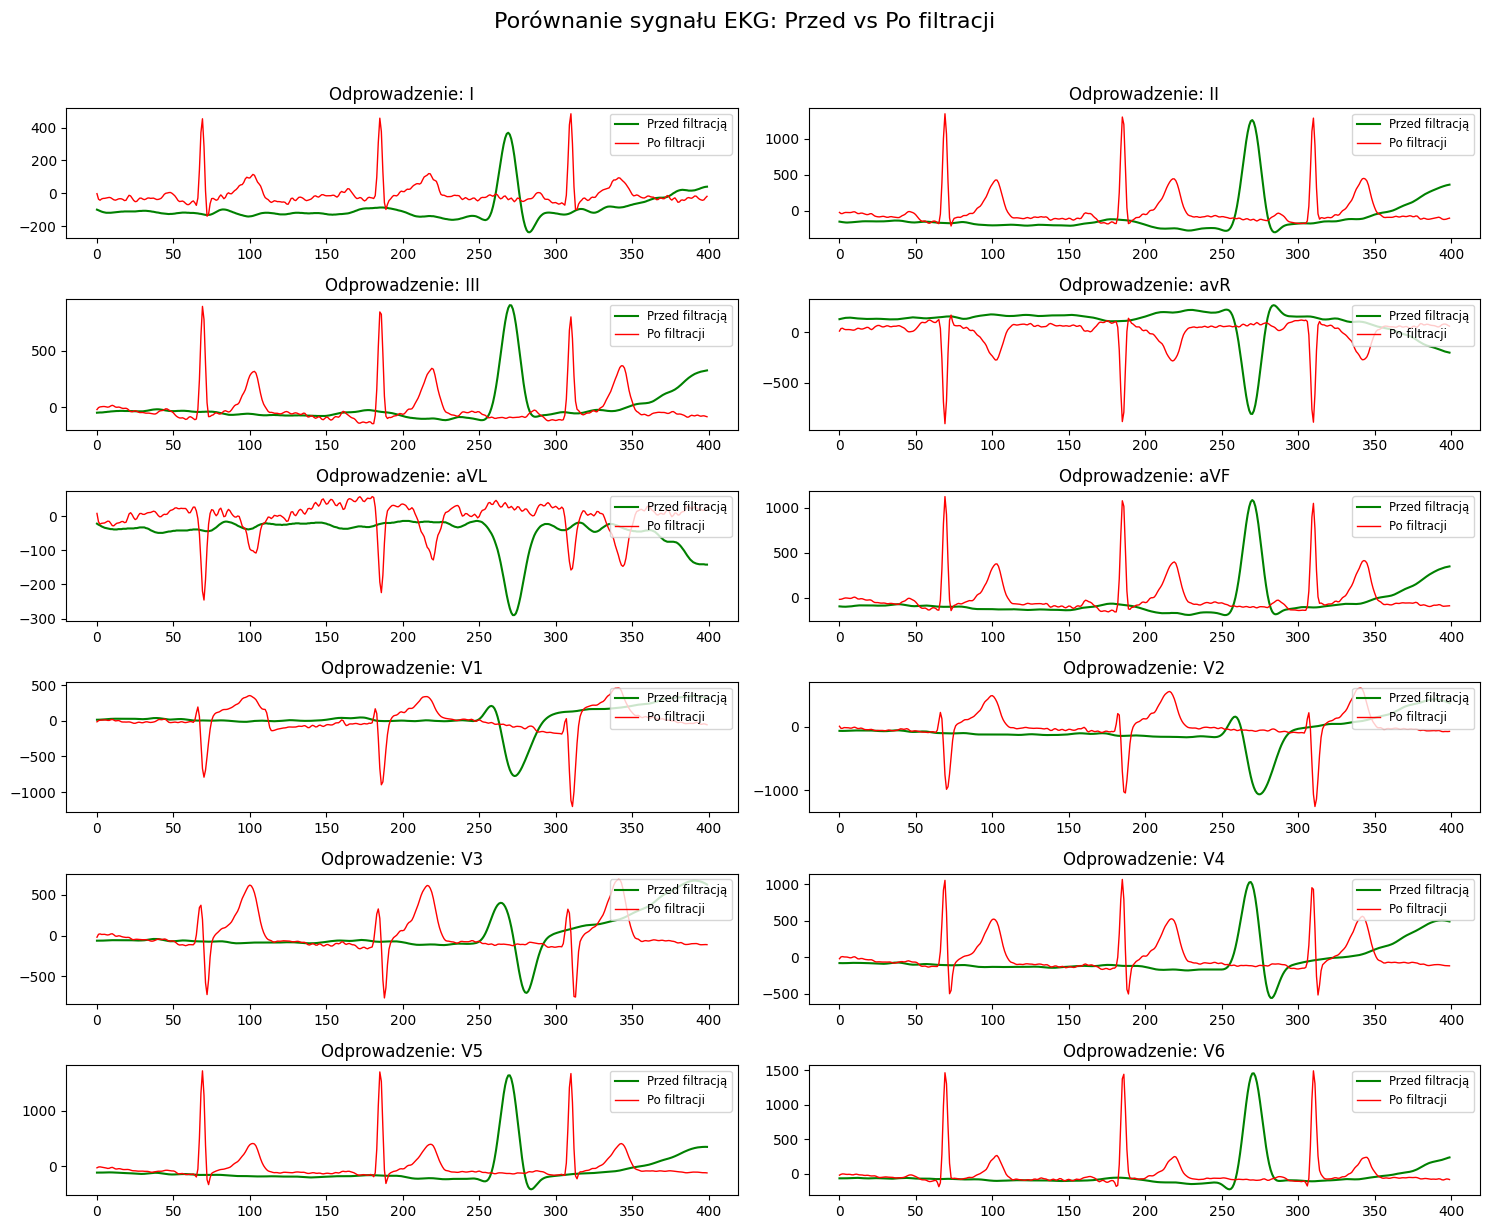

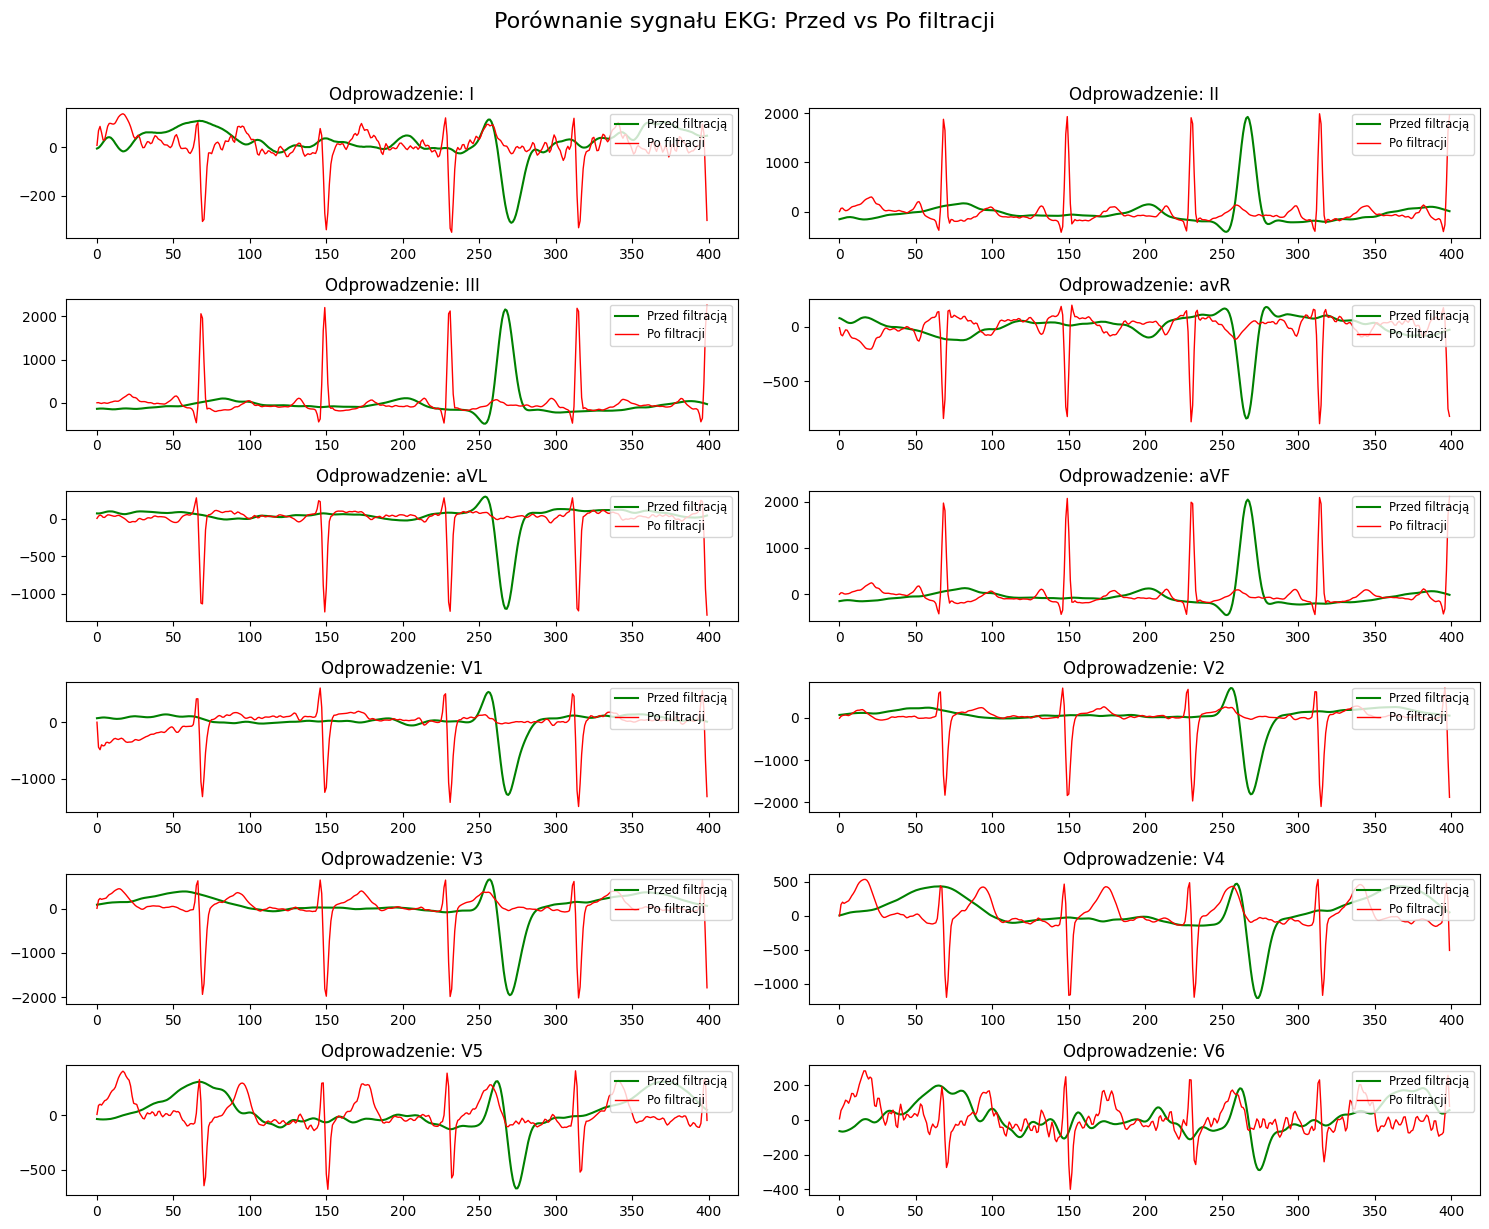

In [16]:
def visualizeMedical(filtered_list_m, df_raw): 
    subset_clean = filtered_list_m.iloc[:400]
    subset_raw = df_raw.iloc[:400]

    columns = subset_clean.columns

    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 12))

    axes = axes.flatten()



    for i, col in enumerate(columns):
        
        subset_raw[col].plot(ax=axes[i], label='Przed filtracją', color='green')
        
        subset_clean[col].plot(ax=axes[i], label='Po filtracji', color='red', linewidth=1)
        
        axes[i].set_title(f"Odprowadzenie: {col}")
        axes[i].legend(loc='upper right', fontsize='small')


    plt.suptitle("Porównanie sygnału EKG: Przed vs Po filtracji", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

for i in range(len(filtered_list_m)):
    visualizeMedical(filtered_list_m[i], raw_list_m[i])



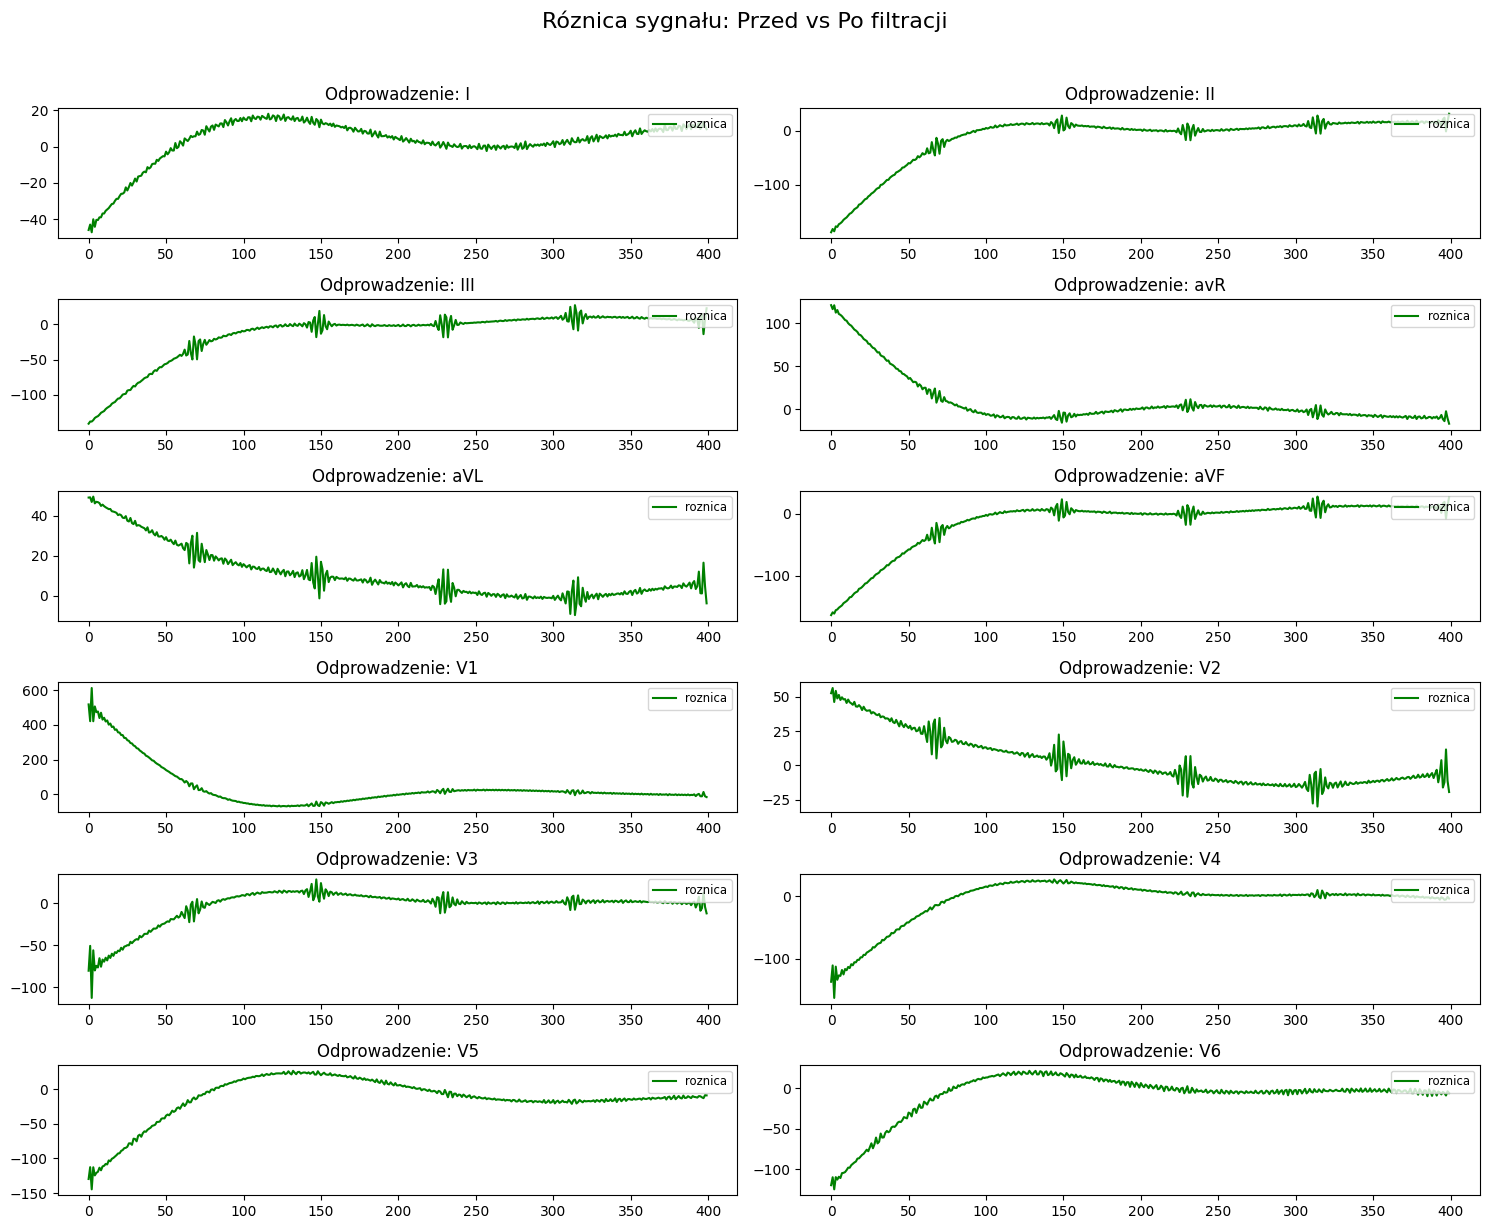

In [9]:
subset_dif =  resampled_df[:400] - subset_clean[:400]


fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 12))

axes = axes.flatten()

columns = subset_clean.columns

for i, col in enumerate(columns):   
    
    subset_dif[col].plot(ax=axes[i], color='green', label='roznica')
    
    axes[i].set_title(f"Odprowadzenie: {col}")
    axes[i].legend(loc='upper right', fontsize='small')


plt.suptitle("Róznica sygnału: Przed vs Po filtracji", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


### Podzial sygnalu na okna
5 sekund w pryzpadku wolniejszego bicia serca, moze dac nie wystarczajaca ilosc uderzen do celu analizy.
Przy normalnym biciu serca w 10 sekunach, zmiesci sie do 15 uderzen, ta ilosc bedzie wystarczajaca do analizy.
Przy próbkowaniu 128 Hz daje to: 10×128=1280 próbek w oknie.


In [10]:
def create_windows(df, window_seconds=10, step_seconds=5, fs=128):
    

    window_samples = int(window_seconds * fs) 
    step_samples = int(step_seconds * fs)     
    
    data_array = df.values 
    total_samples = data_array.shape[0]
    num_channels = data_array.shape[1]
    
    windows = []
    

    for start_index in range(0, total_samples - window_samples + 1, step_samples):
        end_index = start_index + window_samples
        
        
        window = data_array[start_index:end_index, :]
        windows.append(window)
        
    X = np.array(windows)
    
    return X

X_data = create_windows(clean_df, window_seconds=10, step_seconds=5, fs=128)

#### Wyznacznanie outlierów

W celu wyznaczenia outlierów, wartosci, za pomocą których zdecydowano się później wykrywać anomalie w oknach, dokonano wizualizacji danych za pomocą histogramu.


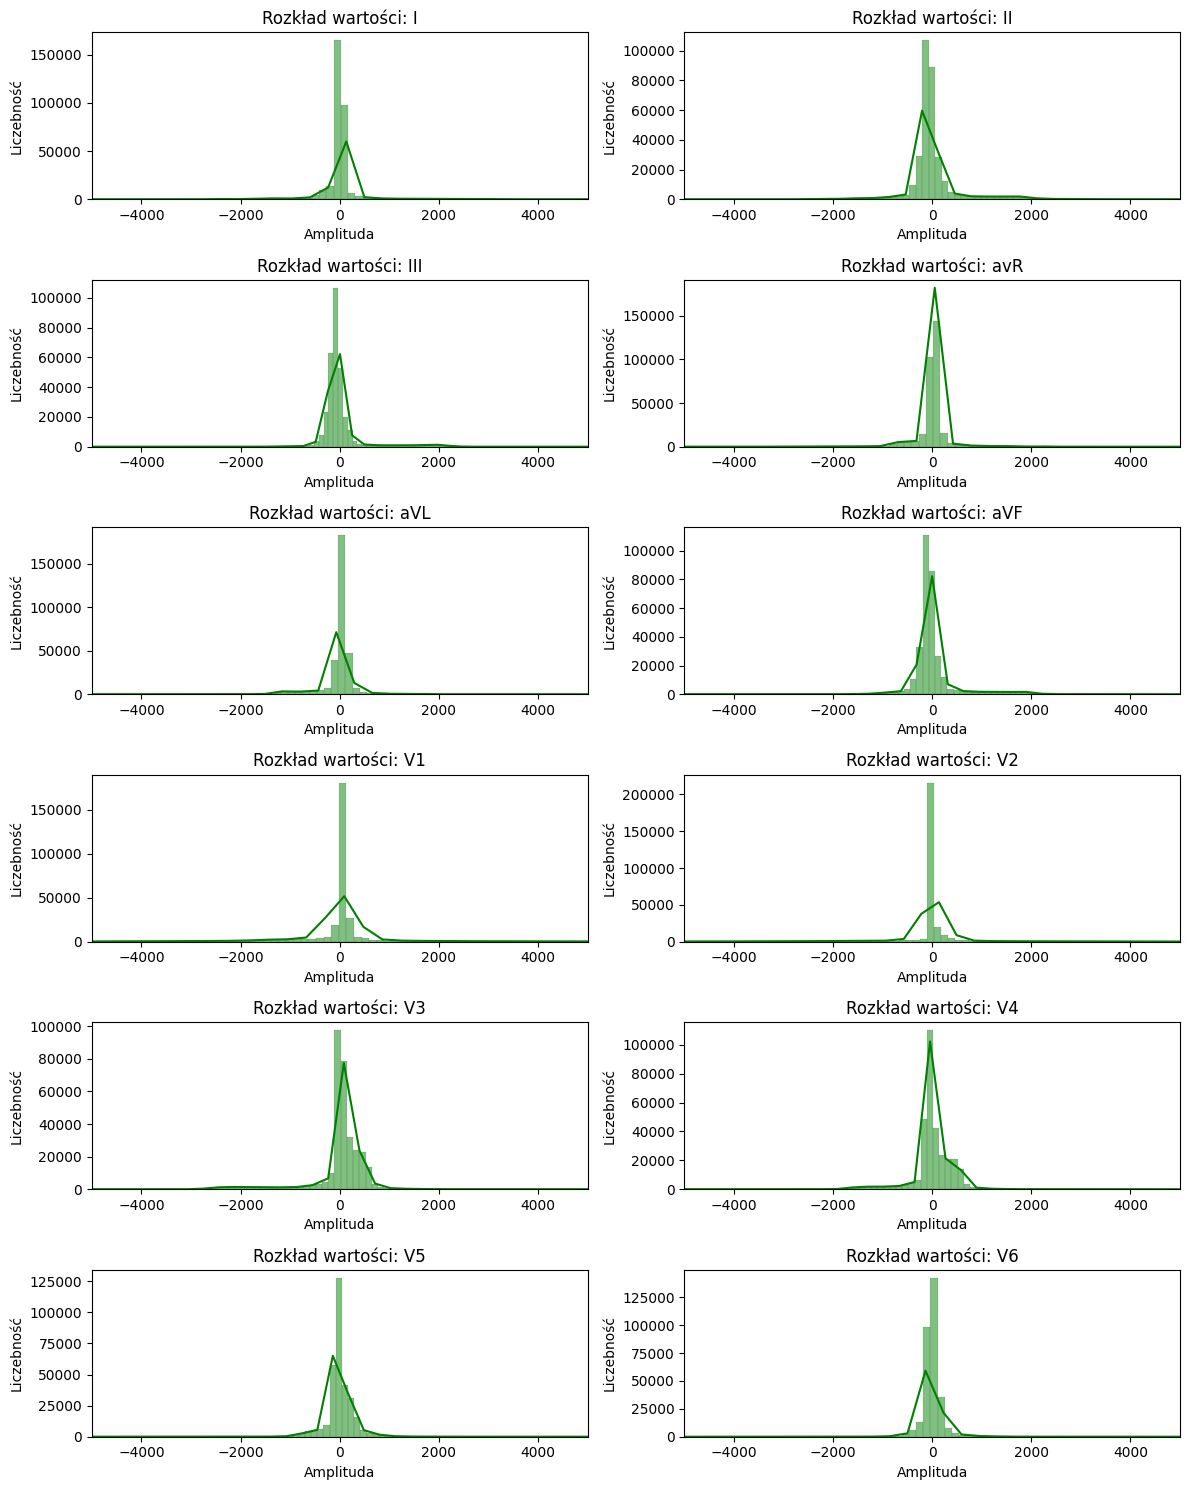

In [11]:
import seaborn as sns

def check_outliers_hist(X_data):

    flattened_data = X_data.reshape(-1, 12) 
    
    
    df_temp = pd.DataFrame(flattened_data, columns=['I','II','III','avR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
    
    figs, axes = plt.subplots(nrows=6, ncols=2, figsize=(12,15))

    axes = axes.flatten()

    columns = df_temp.columns
    for i, col in enumerate(columns):
        sns.histplot(data=df_temp, x=col, ax=axes[i], color='green', kde=True, bins=500)
        

        axes[i].set_xlim(-5000, 5000)
        axes[i].set_title(f"Rozkład wartości: {col}")
        axes[i].set_xlabel("Amplituda")
        axes[i].set_ylabel("Liczebność")
        
    plt.tight_layout()
    plt.show()

X_data = create_windows(clean_df)
check_outliers_hist(X_data)

### Wykrywanie anomalii w oknach
- jesli odchylenie standardowe aplitud w oknie wynosi okolo zera, oznacza najprawdopodniej prosta linie, dlatego pomijamy te wartosci
- jesli maksymalna wartosc w danym oknie wynosi wiecej niz ustalony treshold, w nasyzm przypadku od 3000 do 5000 oznacza wystapienie anomalii,dlatego pomijamy te wartosci.
- jesli róznica pomiaru x i x + 1 jest wieksza niz okreslona wartosc, oznacza za gwałtowną zmianę, wynikającą z zakłócenia, lub zerwania elektrody.

Window jest rozmiaru (1200, 12) oznacza to ze mamy 1200 wartosci w kazdym z kanalow


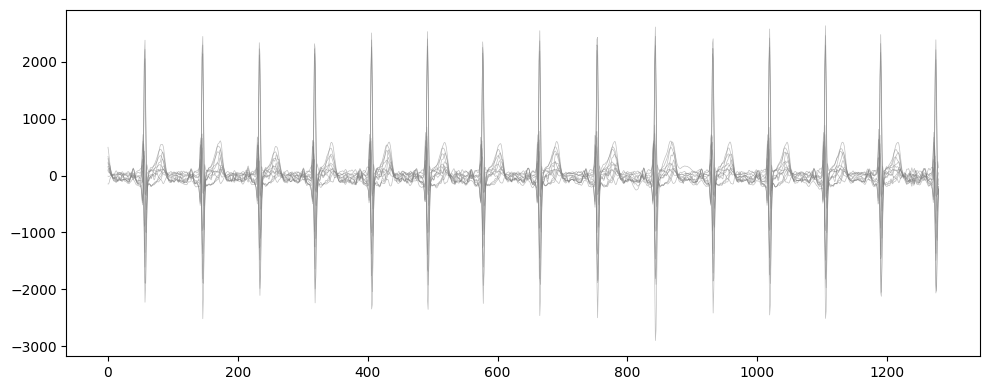

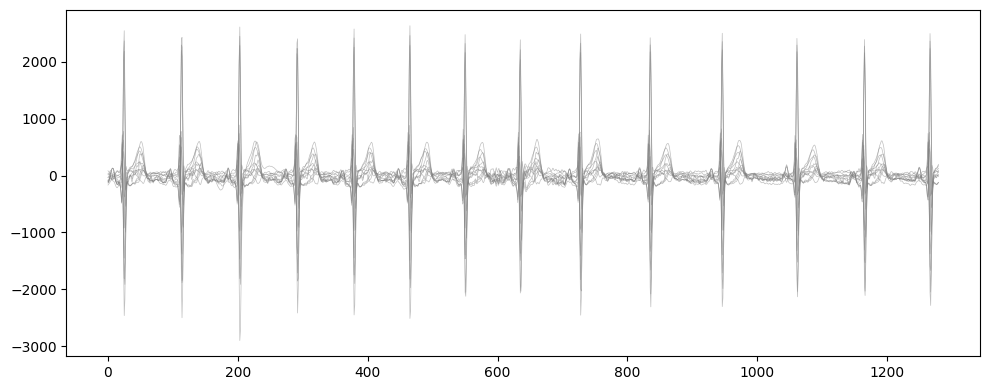

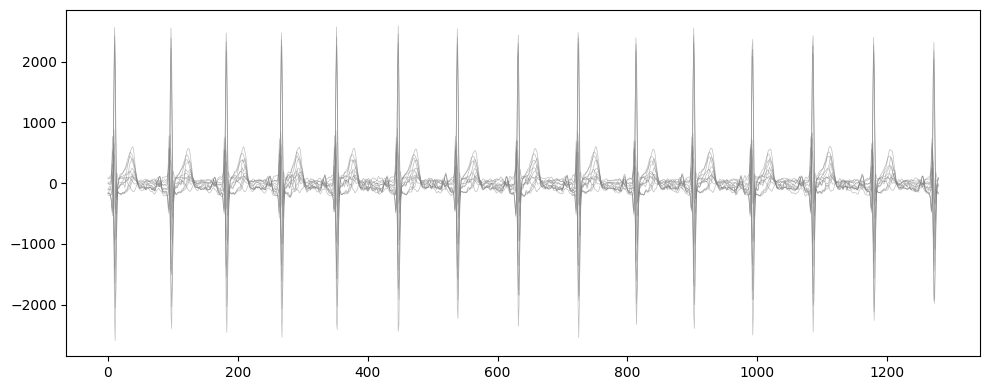

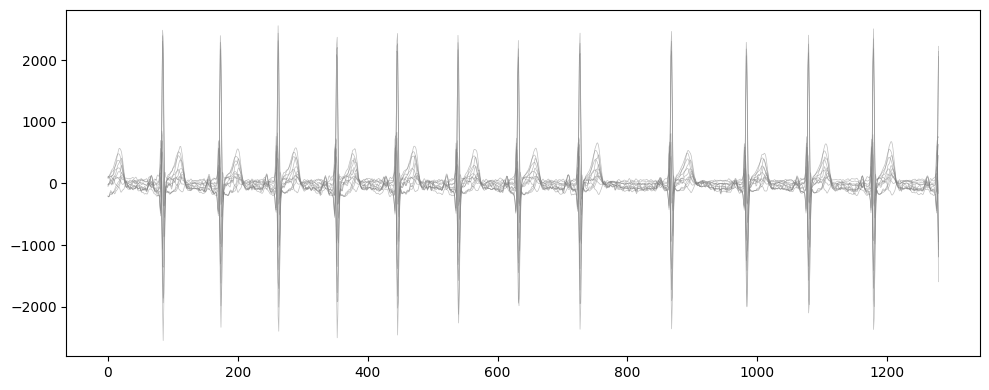

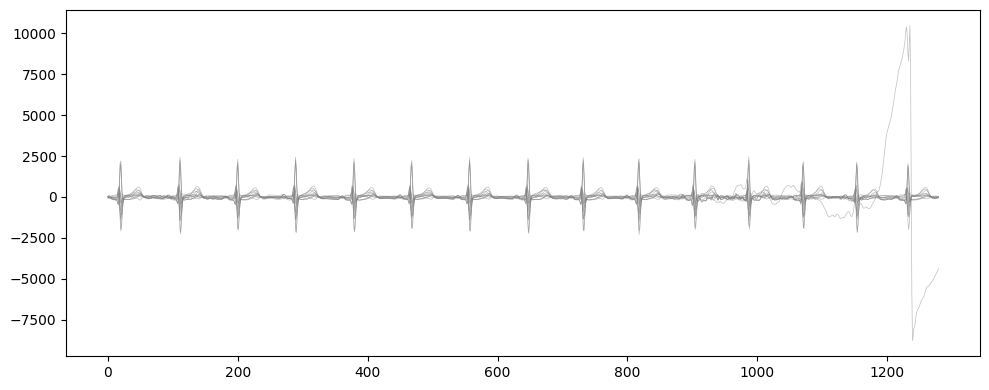

Usunięto 137 okien.
Pozostało 112 dobrych okien.
112
[[[ 8.16349012e+00  6.57258773e+00 -1.64109082e+00 ... -1.59284179e-01
    7.98438342e+00  5.73122413e+00]
  [ 6.90041002e+01  7.14308276e+01  1.42262150e+00 ...  1.66664741e+02
    9.09082744e+01  5.33766986e+01]
  [ 8.66463390e+01  7.66520816e+01 -1.12190737e+01 ...  2.00963487e+02
    1.01568735e+02  7.03010615e+01]
  ...
  [-2.69267927e+01 -8.90885790e+01 -6.12055470e+01 ... -4.65280546e+01
   -6.62417097e+01 -5.89823755e+01]
  [-5.46599546e+00 -8.52994538e+01 -7.97615484e+01 ... -3.59774714e+01
   -3.32567093e+01 -1.97756772e+01]
  [ 2.16180577e+01 -7.42100587e+01 -9.66602650e+01 ... -2.73707866e+01
   -2.31902546e+01 -2.59167817e+01]]

 [[-2.76898510e+02  2.03320630e+03  2.31276131e+03 ... -1.88631320e+02
    1.78721300e+02  1.84496018e+02]
  [-3.81787496e+02  1.27618184e+03  1.66226354e+03 ... -9.61754427e+02
   -3.82374726e+02 -1.36190968e+02]
  [-2.98468812e+02  2.39223659e+02  5.41375525e+02 ... -1.12788083e+03
   -6.077311

In [12]:
import numpy as np

def remove_bad_windows(X, threshold_max_amp=1000, threshold_min_std=1.0):

    
    good_indices = []
    visualize_count = 0
    
    
    
    for i in range(len(X)):
        rejection = False
        window = X[i] # Kształt (1280, 12)

        if np.isnan(window).any():
            rejection = True
            
        stds = np.std(window, axis=0)
        if (stds < threshold_min_std).all():
           
            rejection = True
            
        max_val = np.max(np.abs(window))
        if max_val > threshold_max_amp:
            rejection = True
            

        window_flattened = window.reshape(-1, 12) 
        diffs = np.diff(window_flattened, axis=0)
        if (np.abs(diffs) > 1500).any():
            rejection = True

        

        
        if rejection == False:
            good_indices.append(i)
        elif rejection == True and visualize_count < 5:
            plt.figure(figsize=(10, 4))
            plt.plot(window, color='gray', alpha=0.5, linewidth=0.5)
            plt.tight_layout()
            plt.show()
            visualize_count+=1
        

    X_clean = X[good_indices]
    
    print(f"Usunięto {len(X) - len(X_clean)} okien.")
    print(f"Pozostało {len(X_clean)} dobrych okien.")
    
    return X_clean

X_final = remove_bad_windows(X_data, threshold_max_amp=3000, threshold_min_std=0.5)
print(len(X_final))
X_temp=X_final
print(X_final)

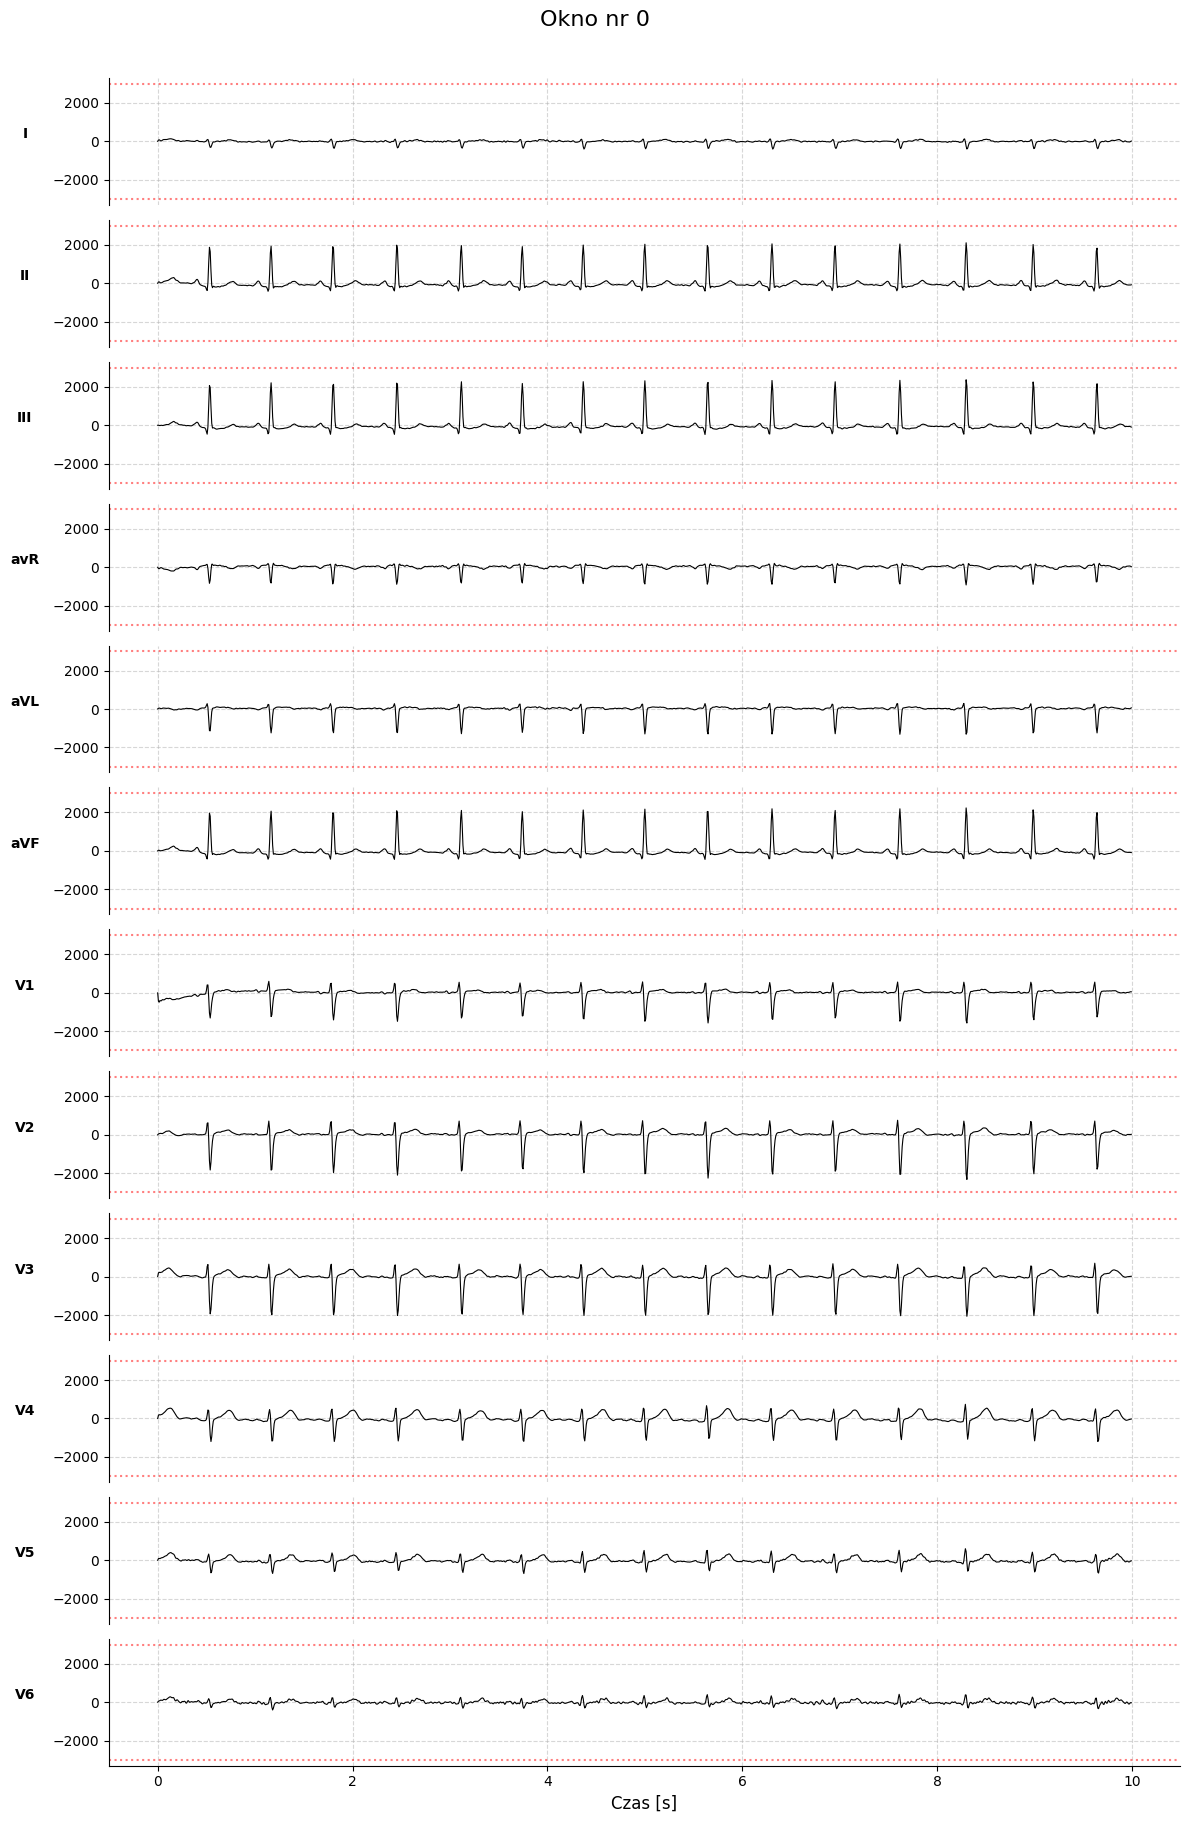

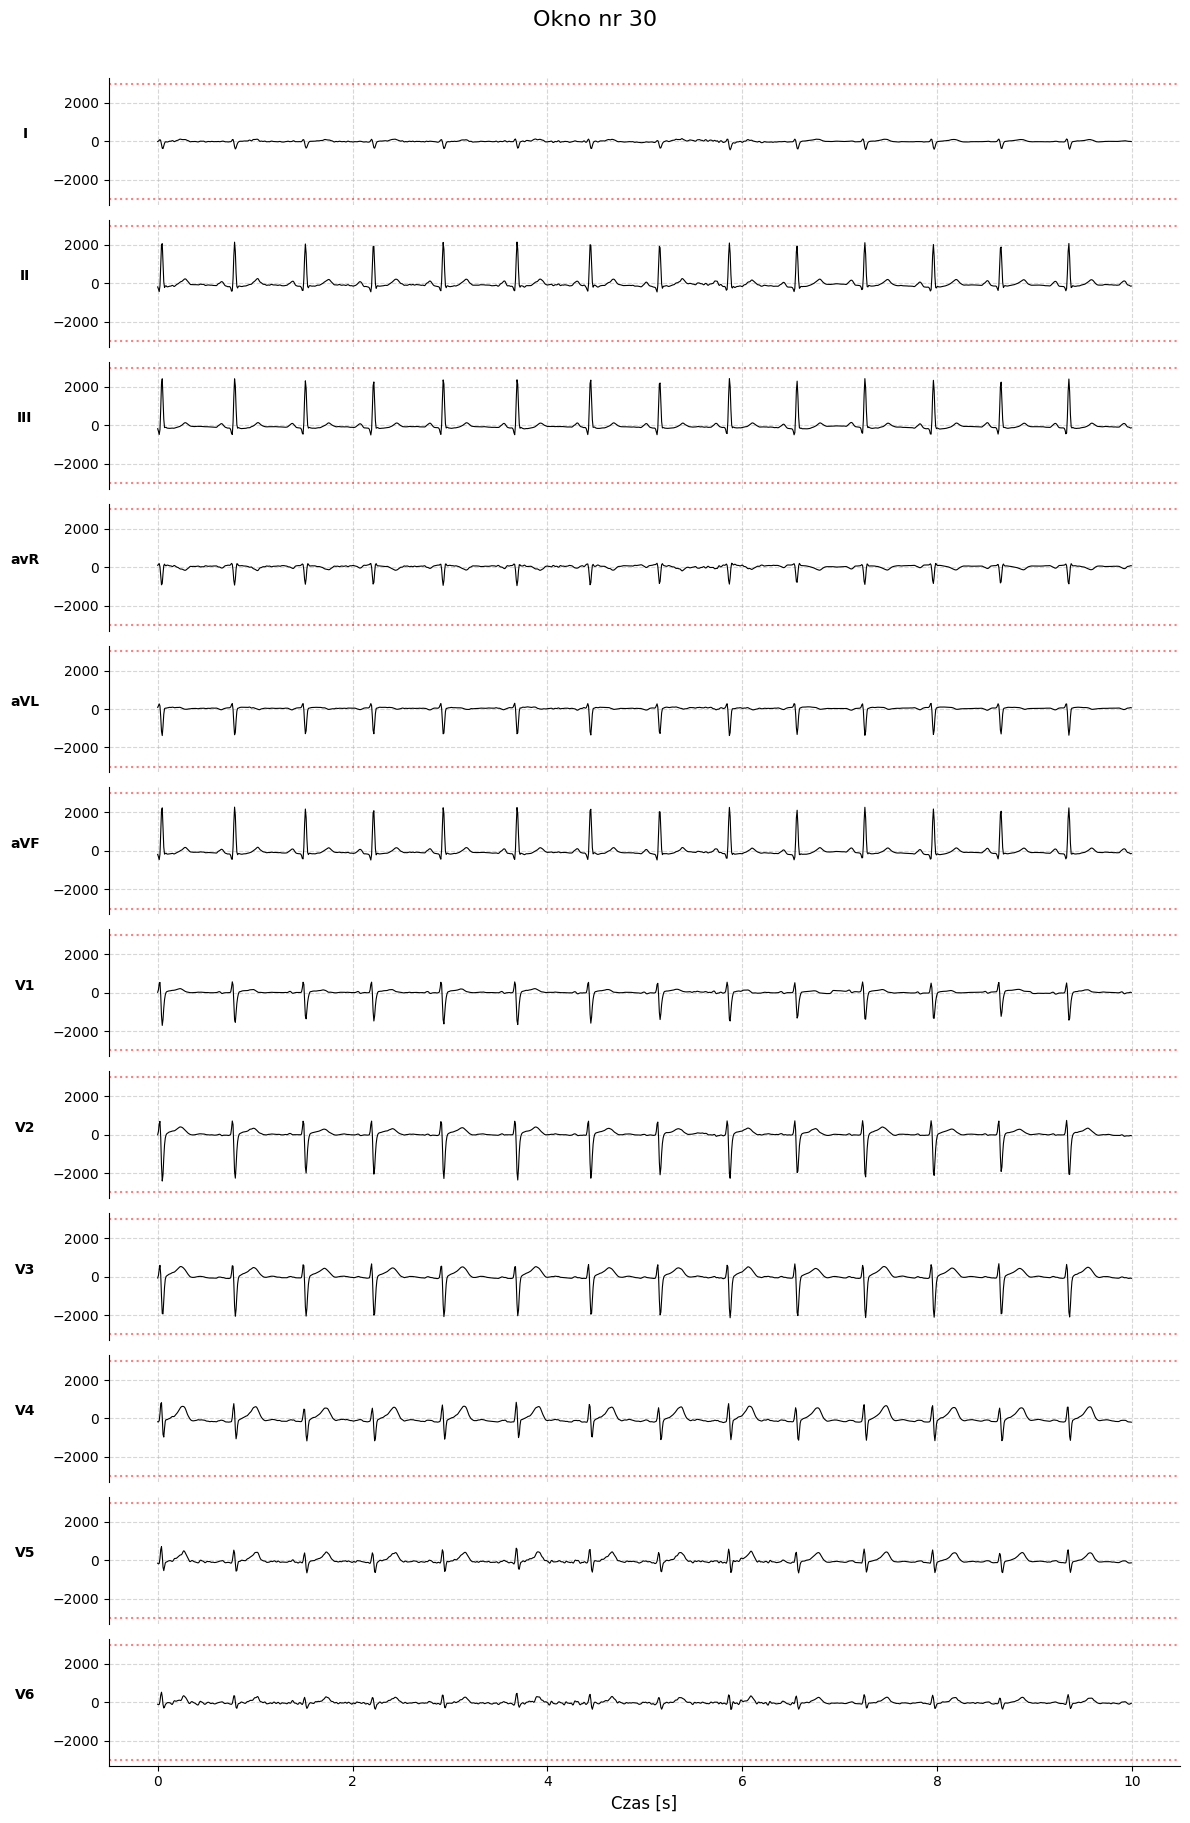

In [ ]:
def visualize_window(X_data, window_index, fs=128, threshold=None):
    

    window = X_data[window_index]
    

    time_axis = np.arange(window.shape[0]) / fs
    

    channels = ['I', 'II', 'III', 'avR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    

    fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(12, 18), sharex=True)
    


    for i in range(12):
        ax = axes[i]
        signal = window[:, i]
        
        ax.plot(time_axis, signal, color='black', linewidth=0.8)
        ax.set_ylabel(channels[i], rotation=0, labelpad=20, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        
        if threshold:
            ax.axhline(y=threshold, color='red', linestyle=':', alpha=0.5)
            ax.axhline(y=-threshold, color='red', linestyle=':', alpha=0.5)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i < 11:
            ax.spines['bottom'].set_visible(False)
            ax.tick_params(bottom=False)

    plt.xlabel("Czas [s]", fontsize=12)
    plt.suptitle(f"Okno nr {window_index}", y=1.01, fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_window(X_final, window_index=0, fs=128, threshold=3000)

visualize_window(X_final, window_index=30, fs=128, threshold=3000)

### Garmin (zegarek) — przetwarzanie JSON

Poniższe komórki wykonują analogiczne operacje dla danych z zegarka (plik JSON):
- ładowanie surowych próbek z JSON
- wykrycie częstotliwości próbkowania (jeśli dostępne)
- resampling do docelowej częstotliwości (domyślnie 128 Hz)
- filtracja pasmowo-przepustowa (używa `filter_ekg` jeśli jest zdefiniowana)
- dzielenie na okna, wizualizacje i zapis przetworzonych danych

In [14]:
import json
#file_path = '/Users/janmichorek/Documents/ProgrammingProjects/HeartAnalisisProject/Projekt-EKG1/Projekt-EKG/data/N36/GARMIN-RECORDINGS/2025-11-14T09-44-17.0_23004d11-0864-4ce7-8a65-fc5b742e4e28.json' 
file_path = 'data/N38/GARMIN-RECORDINGS/2025-11-14T11-01-25.0_5eac28a9-0595-4209-a412-3ec364918395.json'
try:
    with open(file_path, 'r') as f:
        json_data = json.load(f)
        raw_samples = json_data['reading']['samples']
        df_watch = pd.DataFrame(raw_samples, columns=["I"])   
    
    print(f"Wczytano {len(df)} próbek.")

except FileNotFoundError:
    print("Nie znaleziono pliku")



Wczytano 625210 próbek.


In [15]:
#filter watch_df

clean_df_watch = filter_ekg(df_watch)

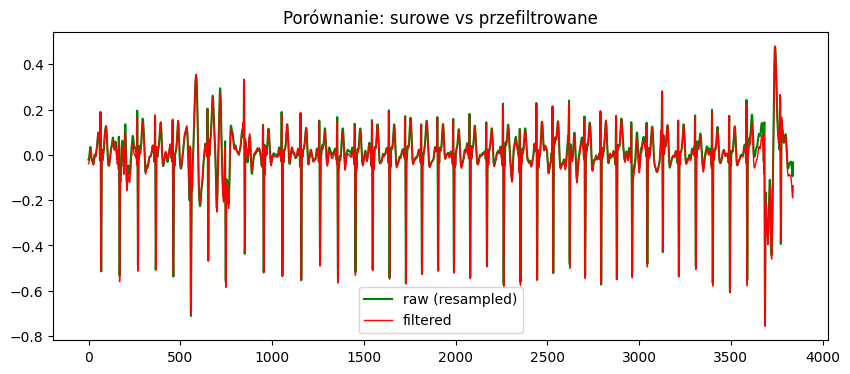

In [16]:
plt.figure(figsize=(10,4))
plt.plot(clean_df_watch, label='raw (resampled)', color='green')
plt.plot(df_watch, label='filtered', color='red', linewidth=1)
plt.title('Porównanie: surowe vs przefiltrowane')
plt.legend()
plt.show()

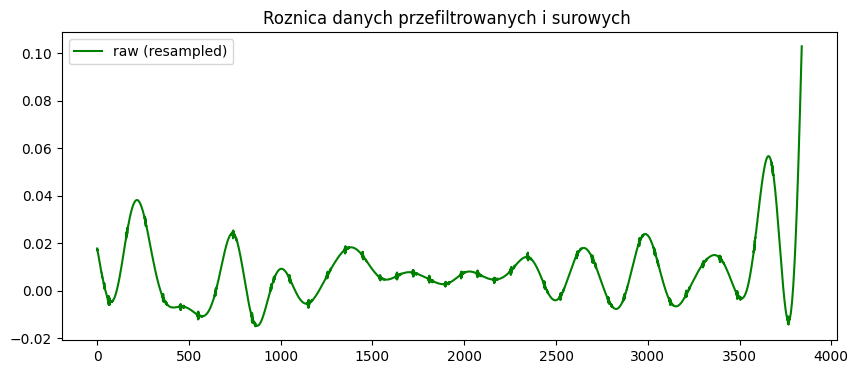

In [17]:
diff_df = clean_df_watch - df_watch

plt.figure(figsize=(10,4))
plt.plot(diff_df, label='raw (resampled)', color='green')
plt.title('Roznica danych przefiltrowanych i surowych ')
plt.legend()
plt.show()

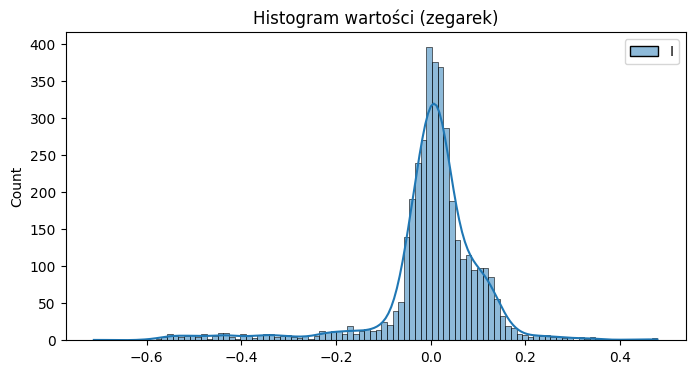

In [18]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.histplot(clean_df_watch, bins=100, kde=True, color='blue')
plt.title('Histogram wartości (zegarek)')
plt.show()

In [19]:
def create_windows(df, window_seconds=10, step_seconds=5, fs=128):
    

    window_samples = int(window_seconds * fs) 
    step_samples = int(step_seconds * fs)     
    
    data_array = df.values 
    total_samples = data_array.shape[0]
    num_channels = data_array.shape[1]
    
    windows = []
    

    for start_index in range(0, total_samples - window_samples + 1, step_samples):
        end_index = start_index + window_samples
        
        
        window = data_array[start_index:end_index, :]
        windows.append(window)
        
    X = np.array(windows)
    print(len(windows))
    
    return X

X_data = create_windows(clean_df_watch, window_seconds=10, step_seconds=5, fs=128)

5


In [20]:
import numpy as np

def remove_bad_windows(X, threshold_max_amp=1, threshold_min_std=0.05):

    
    good_indices = []
    visualize_count = 0
    rejection_reason = None
    
    
    for i in range(len(X)):
        rejection = False
        window = X[i] # Kształt (1280, 1)

        if np.isnan(window).any():
            rejection = True
            rejection_reason = "NanValues"
            
        stds = np.std(window, axis=0)
        if (stds < threshold_min_std).all():
            rejection = True
            rejection_reason = f"too flat (std={stds[0]:.3f})"

            
        max_val = np.max(np.abs(window))
        if max_val > threshold_max_amp:
            rejection = True
            rejection_reason = "maxValue bigger than treshold"
            

        
        diffs = np.diff(window, axis=0)
        if (np.abs(diffs) > 1).any():
            rejection = True
            rejection_reason = "too rapid change"

        

        
        if rejection == False:
            good_indices.append(i)
        elif rejection == True and visualize_count < 5:
            plt.figure(figsize=(10, 4))
            plt.title(rejection_reason)
            plt.plot(window, color='gray', alpha=0.5, linewidth=0.5)
            plt.tight_layout()
            plt.show()
            visualize_count+=1
        

    X_clean = X[good_indices]
    
    print(f"Usunięto {len(X) - len(X_clean)} okien.")
    print(f"Pozostało {len(X_clean)} dobrych okien.")
    
    return X_clean

X_final = remove_bad_windows(X_data, threshold_max_amp=0.8, threshold_min_std=0.1)

Usunięto 0 okien.
Pozostało 5 dobrych okien.


Text(0.5, 1.0, 'Wizualizacja okna nr 0 (Zegarek)')

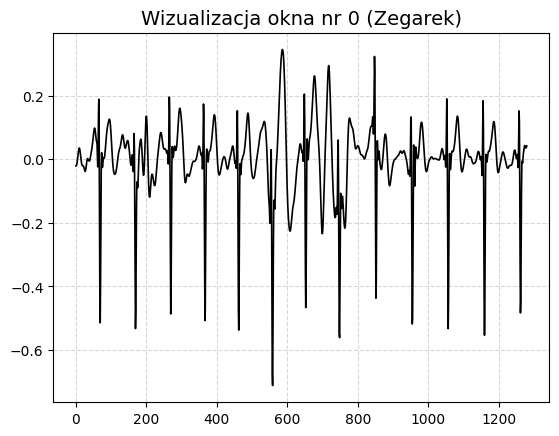

In [21]:
window = X_data[0]
signal = window.flatten()
plt.plot(signal, color='black', linewidth=1.2, label='Sygnał EKG')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title(f"Wizualizacja okna nr 0 (Zegarek)", fontsize=14)





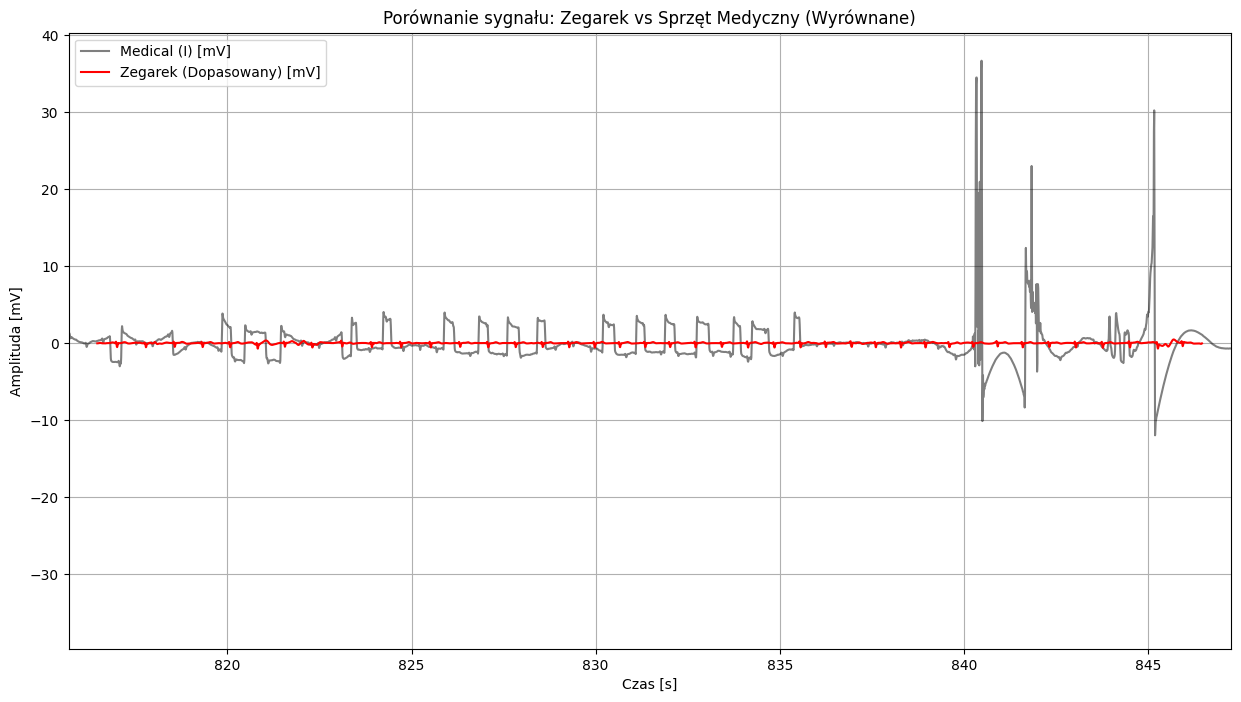

In [22]:
from scipy.signal import correlate

def align_watch_vs_medical(medical_data, watch_data, csv_fs, watch_fs, lead_csv='I'):
    
    sig_long = medical_data[lead_csv].values.flatten()
    
    sig_short = watch_data["I"].values.flatten()

    #zamiana jednostek
    sig_long = sig_long / 1000

    long_centered = sig_long - np.mean(sig_long)
    short_centered = sig_short - np.mean(sig_short)
    
    corr = correlate(long_centered, short_centered, mode='valid')
    best_idx = np.argmax(corr)

    plt.figure(figsize=(15, 8))
    
    t_long = np.arange(len(sig_long)) / 128
    t_short = (np.arange(len(sig_short)) + best_idx) / 128
    
    plt.plot(t_long, sig_long, color='black', alpha=0.5, label=f'Medical ({lead_csv}) [mV]')
    plt.plot(t_short, sig_short, color='red', linewidth=1.5, label='Zegarek (Dopasowany) [mV]')
    
    plt.xlim((best_idx - 100)/128, (best_idx + len(sig_short) + 100)/128)
    
    plt.title("Porównanie sygnału: Zegarek vs Sprzęt Medyczny (Wyrównane)")
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda [mV]")
    plt.legend()
    plt.grid(True)
    plt.show()



align_watch_vs_medical(clean_df, clean_df_watch, csv_fs=500, watch_fs=128, lead_csv='I')

In [ ]:
#pobranie by użyć w z3
import pickle



# 1. BIERZEMY EKG Z X_temp
if 'X_temp' in locals() and len(X_temp) > 0:
    # Sklejamy okna
    ecg_all_leads = np.concatenate(X_temp)
    # Wybieramy Odprowadzenie II (indeks 1)
    if ecg_all_leads.ndim > 1 and ecg_all_leads.shape[1] > 1:
        ecg_ready = ecg_all_leads[:, 1]
    else:
        ecg_ready = ecg_all_leads.flatten() # Jeśli to już była jedna kolumna
    #print(f"✅ EKG (z X_temp): {len(ecg_ready)} próbek (ok. {len(X_temp)} okien).")
else:
    print(" BŁĄD: Brak zmiennej X_temp! Uruchom komórki wyżej w z2.")
    ecg_ready = []

# 2. BIERZEMY ZEGAREK Z X_final
if 'X_final' in locals() and len(X_final) > 0:
    watch_ready = np.concatenate(X_final).flatten()
    #print(f"✅ Zegarek (z X_final): {len(watch_ready)} próbek (ok. {len(X_final)} okien).")
else:
    print(" OSTRZEŻENIE: Brak zmiennej X_final lub jest pusta.")
    watch_ready = []

# 3. ZAPIS DO PLIKU
data_package = {
    "ECG_Clean": ecg_ready,
    "Watch_Clean": watch_ready,
    "fs": 128
}

data_package2 = {
    "ECG_Clean": X_temp,
    "Watch_Clean": X_final,
    "ECG": clean_df,
    "Watch": clean_df_watch,
    "fs": 128
}

with open("clean_data_no_anomalies.pkl", "wb") as f:
    pickle.dump(data_package, f)

with open("z4data.pkl", "wb") as f:
    pickle.dump(data_package2, f)

print(f"\n✅ Zapisano plik 'clean_data_no_anomalies.pkl'.")



✅ Zapisano plik 'clean_data_no_anomalies.pkl'.
